''' -- coding:utf-8 -- @author: Huaiyu Dong ＆ Yixing Huang @Time: 2023-10-23 @Explanition: This code aims to predict the EAB of microwave absorber structure using the XGBoost model. '''

Code execution time: 0.07 seconds
Training R-squared: 0.998
Testing R-squared: 0.645
Training Mean Squared Error: 0.376
Testing Mean Squared Error: 79.855


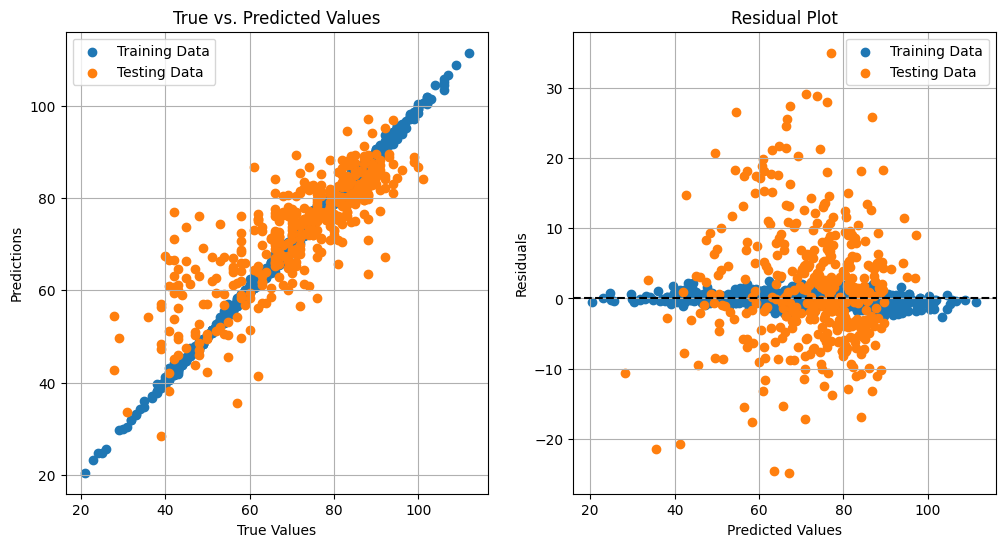

In [1]:
#无集成XGBoost model
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time
# Set random seed for NumPy
#np.random.seed(14618)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data
X = scaler_in.fit_transform(input)
y = scaler_out.fit_transform(EAB.reshape(-1, 1)).ravel()

# Define the ratio for training and testing data
train_ratio = 0.8  # 80% training data
test_ratio = 0.2   # 20% testing data

# Number of samples
n_samples = len(EAB)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
# 记录开始时间
start_time = time.time()


# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# 记录结束时间
end_time = time.time()
# 计算执行时间
execution_time = end_time - start_time
print(f"Code execution time: {execution_time:.2f} seconds")

# Predict with the trained model
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)


# Transform the predictions back to the original scale
y_train_pred = scaler_out.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
y_test_pred = scaler_out.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
y_train_true = scaler_out.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_true = scaler_out.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate the model
train_r2 = r2_score(y_train_true, y_train_pred)
test_r2 = r2_score(y_test_true, y_test_pred)
train_mse = mean_squared_error(y_train_true, y_train_pred)
test_mse = mean_squared_error(y_test_true, y_test_pred)

print(f"Training R-squared: {train_r2:.3f}")
print(f"Testing R-squared: {test_r2:.3f}")
print(f"Training Mean Squared Error: {train_mse:.3f}")
print(f"Testing Mean Squared Error: {test_mse:.3f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_true, y_train_pred, label='Training Data')
plt.scatter(y_test_true, y_test_pred, label='Testing Data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('True vs. Predicted Values')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, y_train_pred - y_train_true, label='Training Data')
plt.scatter(y_test_pred, y_test_pred - y_test_true, label='Testing Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title('Residual Plot')
plt.grid(True)
plt.show()

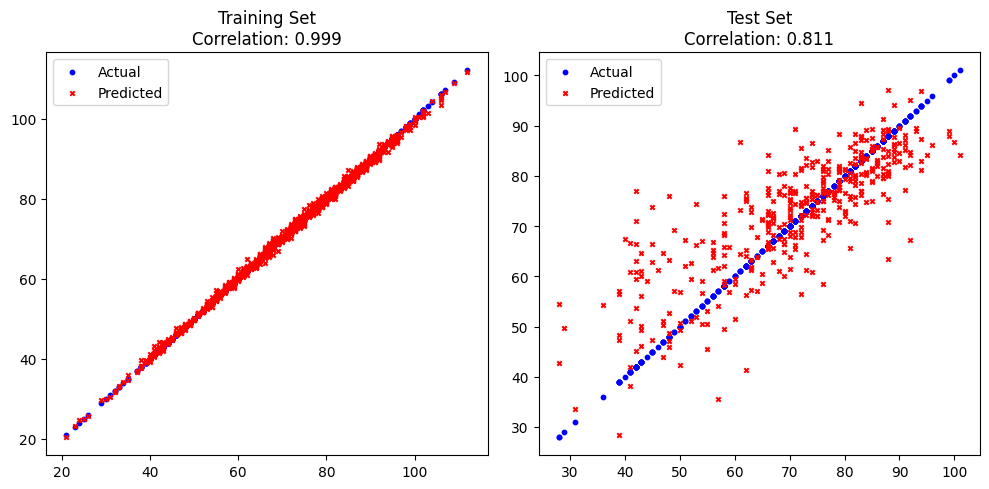

In [2]:
# Additional code to plot correlation
actual_train = y_train_true
predicted_train = y_train_pred
actual_test = y_test_true
predicted_test = y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
#axes[0].set_xlim(-1.2, 1.2)
#axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
axes[0].legend()


# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
#axes[1].set_xlim(-1.2, 1.2)
#axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

#集成XGBoost、随机森林和线性回归的XGBoost元模型
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed for NumPy
np.random.seed(40)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data
X = scaler_in.fit_transform(input)
y = scaler_out.fit_transform(EAB.reshape(-1, 1)).ravel()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14618)

# Initialize and train individual models
xgb_model = xgb.XGBRegressor()
rf_model = RandomForestRegressor()
lr_model = LinearRegression()

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Predict with individual models
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Stack the predictions from individual models
stacked_predictions_train = np.column_stack((y_train_pred_xgb, y_train_pred_rf, y_train_pred_lr))
stacked_predictions_test = np.column_stack((y_test_pred_xgb, y_test_pred_rf, y_test_pred_lr))

# Initialize and train the meta-model (XGBoost)
meta_model = xgb.XGBRegressor()
meta_model.fit(stacked_predictions_train, y_train)

# Predict with the meta-model
meta_train_pred = meta_model.predict(stacked_predictions_train)
meta_test_pred = meta_model.predict(stacked_predictions_test)

# Transform the meta-model's predictions back to the original scale
meta_train_pred = scaler_out.inverse_transform(meta_train_pred.reshape(-1, 1)).ravel()
meta_test_pred = scaler_out.inverse_transform(meta_test_pred.reshape(-1, 1)).ravel()
y_train = scaler_out.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_out.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate the meta-model
meta_train_r2 = r2_score(y_train, meta_train_pred)
meta_test_r2 = r2_score(y_test, meta_test_pred)
meta_train_mse = mean_squared_error(y_train, meta_train_pred)
meta_test_mse = mean_squared_error(y_test, meta_test_pred)

print(f"Meta-Model Training R-squared: {meta_train_r2:.4f}")
print(f"Meta-Model Testing R-squared: {meta_test_r2:.4f}")
print(f"Meta-Model Training Mean Squared Error: {meta_train_mse:.4f}")
print(f"Meta-Model Testing Mean Squared Error: {meta_test_mse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, meta_train_pred, label='Training Data')
plt.scatter(y_test, meta_test_pred, label='Testing Data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('True vs. Predicted Values for Meta-Model')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(meta_train_pred, meta_train_pred - y_train, label='Training Data')
plt.scatter(meta_test_pred, meta_test_pred - y_test, label='Testing Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title('Residual Plot for Meta-Model')
plt.grid(True)
plt.show()

In [3]:
# Additional code to plot correlation
actual_train = y_train
predicted_train = meta_train_pred
actual_test = y_test
predicted_test = meta_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
#axes[0].set_xlim(-1.2, 1.2)
#axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.4f}')
axes[0].legend()


# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
#axes[1].set_xlim(-1.2, 1.2)
#axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

NameError: name 'meta_train_pred' is not defined